# SSE L-Qubit Correlation Matrix Validation

This notebook validates the multi-qubit SSE simulation using the correlation matrix formalism. We simulate a single quantum trajectory and track:

- $\langle\sigma^z_1\rangle(t)$, $\langle\sigma^z_2\rangle(t)$, $\langle\sigma^z_3\rangle(t)$ - magnetization on each site
- $Q(t)$ - cumulative entropy production

The simulation uses `LQubitCorrelationSimulator` which implements stochastic measurement on the correlation matrix $G$ with evolution:

$$\dot{G} = -2i[G,h] + \varepsilon(G\hat{\xi} + \hat{\xi}G - 2G\hat{\xi}G) - \varepsilon^2(G - G^{\text{diag}})$$

where $h$ is the BdG Hamiltonian for XX coupling and $\hat{\xi}$ encodes stochastic measurement outcomes.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from quantum_measurement.jw_expansion.l_qubit_correlation_simulator import LQubitCorrelationSimulator

## Simulation Parameters

We'll simulate a 3-qubit chain with:
- Open boundary conditions
- XX coupling strength $J = 1.0$
- Measurement strength $\varepsilon = 0.1$
- Total time $T = 10.0$
- 1000 time steps

In [36]:
# Simulation parameters
L = 3              # Number of qubits
J = 1.0            # XX coupling strength
epsilon = 0.1      # Measurement strength
T = 100.0           # Total evolution time
N_steps = 100000     # Number of time steps
closed_bc = True  # Closed boundary conditions

# Create simulator
sim = LQubitCorrelationSimulator(
    L=L,
    J=J,
    epsilon=epsilon,
    N_steps=N_steps,
    T=T,
    closed_boundary=closed_bc,
    rng=np.random.default_rng(42)  # Fixed seed for reproducibility
)

print(f"Simulator configured:")
print(f"  L = {L} qubits")
print(f"  J = {J}")
print(f"  ε = {epsilon}")
print(f"  T = {T}")
print(f"  dt = {sim.dt:.4f}")
print(f"  Boundary: {'Periodic' if closed_bc else 'Open'}")

Simulator configured:
  L = 3 qubits
  J = 1.0
  ε = 0.1
  T = 100.0
  dt = 0.0010
  Boundary: Periodic


## Run Single Trajectory

Simulate one quantum trajectory and extract:
- `Q`: Total entropy production
- `z_traj`: Magnetization $\langle\sigma^z_i\rangle(t)$ for each site (shape: `N_steps+1 × L`)
- `xi_traj`: Measurement outcomes $\xi_i(t) \in \{-1, +1\}$ (shape: `N_steps × L`)

In [37]:
# Simulate single trajectory
Q_total, z_traj, xi_traj = sim.simulate_trajectory()

print(f"Trajectory simulation complete!")
print(f"  Total entropy production Q = {Q_total:.4f}")
print(f"  z_traj shape: {z_traj.shape}")
print(f"  xi_traj shape: {xi_traj.shape}")
print(f"\nInitial magnetizations:")
for i in range(L):
    print(f"  ⟨σ^z_{i+1}⟩(0) = {z_traj[0, i]:.4f}")
print(f"\nFinal magnetizations:")
for i in range(L):
    print(f"  ⟨σ^z_{i+1}⟩(T) = {z_traj[-1, i]:.4f}")

Trajectory simulation complete!
  Total entropy production Q = 5531.9635
  z_traj shape: (100001, 3)
  xi_traj shape: (100000, 3)

Initial magnetizations:
  ⟨σ^z_1⟩(0) = 1.0000
  ⟨σ^z_2⟩(0) = 1.0000
  ⟨σ^z_3⟩(0) = 1.0000

Final magnetizations:
  ⟨σ^z_1⟩(T) = -0.9675
  ⟨σ^z_2⟩(T) = -0.9891
  ⟨σ^z_3⟩(T) = 0.9793


## Compute Cumulative Entropy Production Q(t)

The total entropy production `Q_total` returned by the simulator is the final value. To plot $Q(t)$ vs time, we need to recompute the cumulative sum using the Stratonovich discretization:

$$Q(t_{n+1}) = Q(t_n) + \sum_i \left[2\varepsilon^2 z_{\text{before},i} \frac{z_{\text{before},i} + z_{\text{after},i}}{2} + 2\varepsilon\xi_i \frac{z_{\text{before},i} + z_{\text{after},i}}{2}\right]$$

In [38]:
# Recompute Q(t) step-by-step for plotting
Q_cumulative = np.zeros(N_steps + 1)
Q_cumulative[0] = 0.0

for step in range(N_steps):
    z_before = z_traj[step]
    z_after = z_traj[step + 1]
    xi = xi_traj[step]
    
    dQ = 0.0
    for i in range(L):
        avg_z = 0.5 * (z_before[i] + z_after[i])
        dQ += 2.0 * epsilon**2 * z_before[i] * avg_z
        dQ += 2.0 * epsilon * xi[i] * avg_z
    
    Q_cumulative[step + 1] = Q_cumulative[step] + dQ

print(f"Recomputed Q(T) = {Q_cumulative[-1]:.4f}")
print(f"Original Q_total = {Q_total:.4f}")
print(f"Difference: {abs(Q_cumulative[-1] - Q_total):.6e}")

Recomputed Q(T) = 5531.9635
Original Q_total = 5531.9635
Difference: 1.955414e-10


## Plot Magnetization vs Time

Plot $\langle\sigma^z_i\rangle(t)$ for each site $i = 1, 2, 3$.

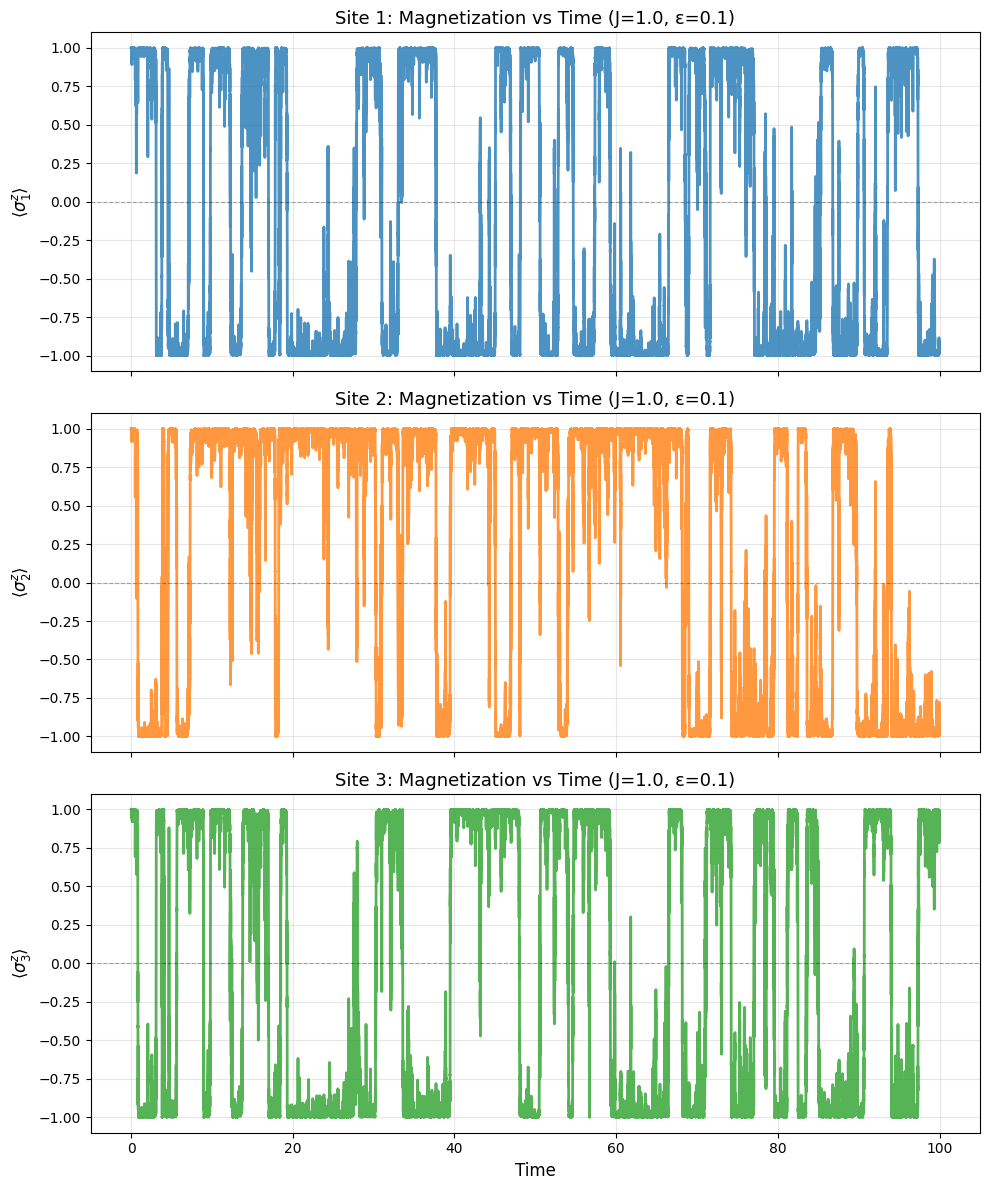

In [39]:
# Time array
times = np.linspace(0, T, N_steps + 1)

# Create three separate plots for each site
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i in range(L):
    ax = axes[i]
    ax.plot(times, z_traj[:, i], color=colors[i], linewidth=2, alpha=0.8)
    
    ax.set_ylabel(f'$\\langle\\sigma^z_{i+1}\\rangle$', fontsize=12)
    ax.set_title(f'Site {i+1}: Magnetization vs Time (J={J}, ε={epsilon})', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=0.8)
    ax.set_ylim(-1.1, 1.1)
    
    if i < L - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time', fontsize=12)

plt.tight_layout()
plt.show()

## Plot Entropy Production vs Time

Plot the cumulative entropy production $Q(t)$.

Calculated A = ⟨z_1^2⟩ = 0.8772


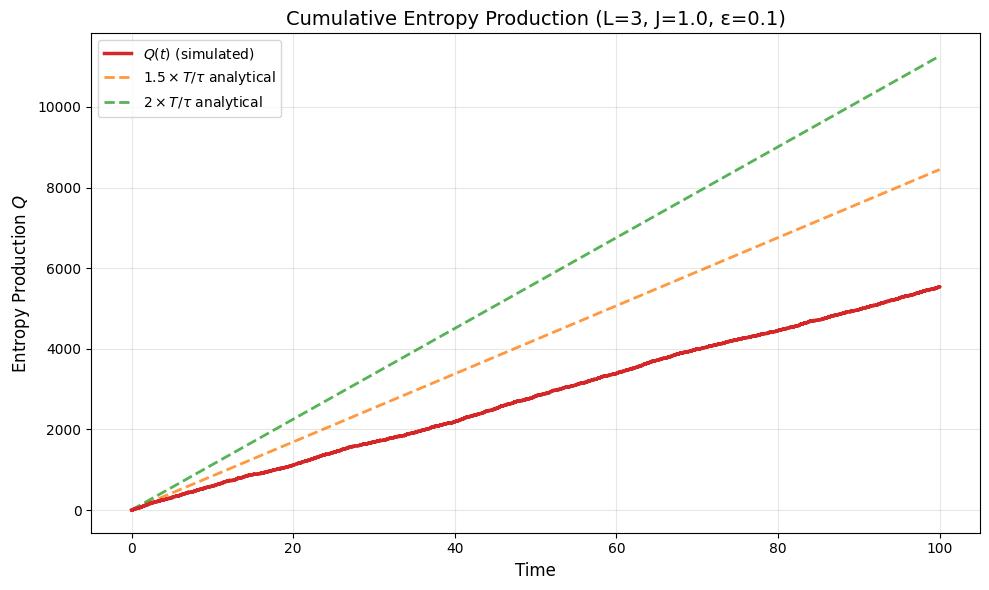


Average entropy production rate: dQ/dt ≈ 55.3196
Theoretical T/τ = 5631.6637
Simulated Q(T) / Theoretical = 0.9823


In [40]:
# Plot entropy production
fig, ax = plt.subplots(figsize=(10, 6))

# Simulated Q(t)
ax.plot(times, Q_cumulative, color='#d62728', linewidth=2.5, label='$Q(t)$ (simulated)', zorder=3)

# Calculate A from simulation results using <z_1^2>
A_calculated = np.mean(z_traj[:, 1]**2)
print(f"Calculated A = ⟨z_1^2⟩ = {A_calculated:.4f}")

# Analytical predictions: T/tau = N_steps * epsilon^2
T_over_tau = N_steps * epsilon**2
theoretical_total = T_over_tau * L * (A_calculated + 1.0)

# Linear analytical solutions
analytical_1x = (times / T) * theoretical_total
analytical_1_5x = (times / T) * 1.5 * theoretical_total
analytical_2x = (times / T) * 2.0 * theoretical_total

ax.plot(times, analytical_1_5x, '--', color='#ff7f0e', linewidth=2, 
        label=f'$1.5 \\times T/\\tau$ analytical', alpha=0.8, zorder=2)
ax.plot(times, analytical_2x, '--', color='#2ca02c', linewidth=2, 
        label=f'$2 \\times T/\\tau$ analytical', alpha=0.8, zorder=2)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Entropy Production $Q$', fontsize=12)
ax.set_title(f'Cumulative Entropy Production (L={L}, J={J}, ε={epsilon})', fontsize=14)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute average entropy production rate
avg_rate = Q_total / T
print(f"\nAverage entropy production rate: dQ/dt ≈ {avg_rate:.4f}")
print(f"Theoretical T/τ = {theoretical_total:.4f}")
print(f"Simulated Q(T) / Theoretical = {Q_total / theoretical_total:.4f}")